In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import string
import re
import os
import sys

import tensorflow
import keras
import h5py
import progressbar

import spacy
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm

# Machine Learning packages
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from collections import Counter
from wordcloud import WordCloud

from keras import regularizers, initializers, optimizers, callbacks
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from keras.layers import *
from keras.models import Model

from pickle import load
import numpy as np
import argparse
from keras.preprocessing.sequence import pad_sequences
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from keras.models import load_model
from nltk.translate.bleu_score import corpus_bleu


PATH_CURRENT = '/home/jupyter/meme_hateful_detection'

PATH_CODE = f'{PATH_CURRENT}/src'
PATH_DATA = f'{PATH_CURRENT}/data'
PATH_MODEL = f'{PATH_CURRENT}/models'
PATH_NOTEBOOKS = f'{PATH_CURRENT}/notebooks'

PATH_DEV_IMAGES = f'{PATH_CURRENT}/data/raw/flickr8k_images'
PATH_TEST_IMAGES = f'{PATH_CURRENT}/data/raw/test_images'
PATH_TRAIN_IMAGES = f'{PATH_CURRENT}/data/raw/flickr8k_images'
PATH_TRAIN_IMAGES_TEXT = f'{PATH_CURRENT}/data/raw/flickr8k_images_text'
PATH_TRAIN_MEMES = f'{PATH_CURRENT}/data/raw/facebook_memes'
PATH_MEMES_DATASET = f'{PATH_CURRENT}/data/raw/meme_dataset'
PATH_INTERIM = f'{PATH_CURRENT}/data/interim'

PATH_IMAGE_GENERATOR = f'{PATH_CODE}/cap_generator'

# module_path = PATH_CURRENT
if PATH_CURRENT not in sys.path:
    sys.path.append(PATH_CURRENT)
if PATH_CODE not in sys.path:
    sys.path.append(PATH_CODE)
if PATH_MODEL not in sys.path:
    sys.path.append(PATH_MODEL)
if PATH_TRAIN_IMAGES_TEXT not in sys.path:
    sys.path.append(PATH_TRAIN_IMAGES_TEXT)
if PATH_TEST_IMAGES not in sys.path:
    sys.path.append(PATH_TEST_IMAGES)
if PATH_IMAGE_GENERATOR not in sys.path:
    sys.path.append(PATH_IMAGE_GENERATOR)
    

from cap_generator import load_data as ld
from cap_generator import generate_model as gen
from cap_generator import eval_model as em  
# print(sys.path)

import warnings
warnings.filterwarnings('ignore')

In [5]:
MAX_NB_WORDS = 3000000    # max no. of words for tokenizer
MAX_SEQUENCE_LENGTH = 200 # max length of each entry (sentence), including padding
VALIDATION_SPLIT = 0.2   # data for validation (not used in training)
EMBEDDING_DIM = 100      # embedding dimensions for word vectors (word2vec/GloVe)
GLOVE_DIR = "glove/glove.6B."+str(EMBEDDING_DIM)+"d.txt"

In [6]:
spacy_nlp = spacy.load('en_core_web_sm')
stopwords = spacy.lang.en.stop_words.STOP_WORDS
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner']) 
nlp.max_length = MAX_NB_WORDS 

#  1. Exploratory Data Analysis

## Context
As said above, we've worked on a dataset of job descriptions and their meta information in which a small proportion of these descriptions were fake or scam, which can be identified by the column "fraudulent".

## Data files
train.jsonl - the training set
dev.jsonl - the development set
test.jsonl - the test set

### Columns
* id:  Meme id
* img: Meme image file
* text: A string representing the text in the meme image
* label: Probability that the meme is hateful.

In [10]:
df_memes_dev = pd.read_json(f'{PATH_MEMES_DATASET}/dev.jsonl', lines=True, orient='records')
df_memes_dev = df_memes_dev[0:20]
df_memes_dev.head()

,id,img,label,text
0,8291,img/08291.png,1,white people is this a shooting range
1,46971,img/46971.png,1,bravery at its finest
2,3745,img/03745.png,1,your order comes to $37.50 and your white priv...
3,83745,img/83745.png,1,it is time.. to send these parasites back to t...
4,80243,img/80243.png,1,mississippi wind chime


In [8]:
df_memes_train = pd.read_json(f'{PATH_MEMES_DATASET}/train.jsonl', lines=True, orient='records')
df_memes_train.head()

,id,img,label,text
0,42953,img/42953.png,0,its their character not their color that matters
1,23058,img/23058.png,0,don't be afraid to love again everyone is not ...
2,13894,img/13894.png,0,putting bows on your pet
3,37408,img/37408.png,0,i love everything and everybody! except for sq...
4,82403,img/82403.png,0,"everybody loves chocolate chip cookies, even h..."


In [9]:
df_memes_test = pd.read_json(f'{PATH_MEMES_DATASET}/test.jsonl', lines=True, orient='records')
df_memes_test.head()

,id,img,text
0,16395,img/16395.png,handjobs sold seperately
1,37405,img/37405.png,introducing fidget spinner for women
2,94180,img/94180.png,happy pride month let's go beat up lesbians
3,54321,img/54321.png,laughs in [majority of u.s crime rate]
4,97015,img/97015.png,finds out those 72 virgins.. are goats


In [11]:
df_memes_normal  = df_memes_train[df_memes_train['label']==0]
df_memes_hateful = df_memes_train[df_memes_train['label']==1]

# 2. Word Exploratory Data Analisis

In [12]:
df_memes_train['text'].isna().value_counts()

False    8500
Name: text, dtype: int64

In [13]:
def series_to_str(series_column):
    '''This function converts a series to text, concatenating its values'''
    return(' '.join(series_column))
    
def clean_text(str_text_raw):
    '''This function clean a given '''
    str_text = str_text_raw.lower()
    return(str_text)
  
def clean_image_path(str_image):
    str_image_clean = str_image.replace('img/','')
    return(str_image_clean)

In [24]:
def string_to_token(string, str_pickle = None):
    '''
    This function takes a sentence and returns the list of tokens and all their information
    * Text: The original text of the lexeme.
    * Lemme: Lexeme.
    * Orth: The hash value of the lexeme.
    * is alpha: Does the lexeme consist of alphabetic characters?
    * is digit: Does the lexeme consist of digits?
    * is_title: Is the token in titlecase? 
    * is_punct: Is the token punctuation?
    * is_space: Does the token consist of whitespace characters?
    * is_stop: Is the token part of a “stop list”?
    * is_digit: Does the token consist of digits?
    * lang: Language of the token
    * tag: Fine-grained part-of-speech. The complete list is in: 
    https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html, also using: spacy.explain("RB")
    * pos: Coarse-grained part-of-speech.
    * has_vector: A boolean value indicating whether a word vector is associated with the token.
    * vector_norm: The L2 norm of the token’s vector representation.
    * is_ovv: '''
    doc = nlp(string)
    l_token = [[token.text, token.lemma_, token.orth, token.is_alpha, token.is_digit, token.is_title, token.lang_, 
        token.tag_, token.pos_, token.has_vector, token.vector_norm, token.is_oov]
        for token in doc if not token.is_punct | token.is_space | token.is_stop | token.is_digit | token.like_url 
               | token.like_num | token.like_email & token.is_oov]
    df_token = pd.DataFrame(l_token, columns=['text', 'lemme', 'orth', 'is_alpha', 'is_digit', 'is_title', 'language',
                                          'tag', 'part_of_speech', 'has_vector', 'vector_norm', 'is_oov'])
    #Convert plural text to singular
    df_token['text_to_singular'] = np.where(df_token['tag'].isin(['NNPS', 'NNS']), df_token['lemme'], df_token['text'])
    if(str_pickle!=None):
        df_token.to_pickle(f'../data/pickles/{str_pickle}.pkl')
    del l_token
    return(df_token)

def list_to_bow(l_words):
    '''
    This function takes a list of words and create the bag of words ordered by desc order
    '''
    cv = CountVectorizer(l_words)
    # show resulting vocabulary; the numbers are not counts, they are the position in the sparse vector.
    count_vector=cv.fit_transform(l_words)
    word_freq = Counter(l_words)
    print(f'Bag of words size: {count_vector.shape}\nUnique words size: {len(word_freq)}')
    dict_word_freq = dict(word_freq.most_common())
    return(dict_word_freq)

def create_wordcloud(dict_words, b_plot=False):
    wordcloud = WordCloud(width = 1000, height = 500, normalize_plurals=True).generate_from_frequencies(dict_words)
    if(b_plot==True):
      plt.figure(figsize=(20,8))
      plt.imshow(wordcloud)
      plt.axis('off')
      plt.title("Most lemma words", fontsize=25)
      plt.show
    return(wordcloud)

def apply_cleaning(string):
    '''
    This function takes a sentence and returns a clean text
    '''
    doc = nlp(clean_text(string))
    l_token = [token.text for token in doc if not token.is_punct | token.is_space | token.is_stop | 
               token.is_digit | token.like_url | token.like_num | token.like_email & token.is_oov]
    return ' '.join(l_token)

def apply_lemma(string):
    '''
    This function takes a sentence and returns a clean text
    '''
    doc = nlp(clean_text(string))
    l_token = [token.lemma_ for token in doc if not token.is_punct | token.is_space | token.is_stop | 
               token.is_digit | token.like_url | token.like_num | token.like_email & token.is_oov]
    return ' '.join(l_token)

def generate_description(image_file):
  tokenizer = load(open(f'{PATH_MODEL}/tokenizer.pkl', 'rb'))
  index_word = load(open(f'{PATH_MODEL}/index_word.pkl', 'rb'))
  # pre-define the max sequence length (from training)
  max_length = 34

  # load the model
  filename = f'{PATH_MODEL}/model_weight.h5'
  model = load_model(filename)

  image=f'/home/jupyter/meme_hateful_detection/data/raw/facebook_memes/{image_file}'
  print(image)
  if(os.path.exists(image)):  
    photo = em.extract_features(image)
    # generate description
    captions = em.generate_desc(model, tokenizer, photo, index_word, max_length)
    text_image = []
    for cap in captions:
      # remove start and end tokens
      seq = cap[0].split()[1:-1]
      desc = ' '.join(seq)
      text_image.append(desc)
#       print('{} [log prob: {:1.2f}]'.format(desc,cap[1]))
    del image
    del captions
    return(text_image)
  else:
    return([''])

In [15]:
str_text_total   = series_to_str(df_memes_train.text)
str_text_normal  = series_to_str(df_memes_normal.text)
str_text_hateful = series_to_str(df_memes_hateful.text)
print(f'Total bow with length: {len(str_text_total)}')
print(f'Total normal memes with length: {len(str_text_normal)}')
print(f'Total hateful memes with length: {len(str_text_hateful)}')

Total bow with length: 536143
Total normal memes with length: 324218
Total hateful memes with length: 211924


In [16]:
str_text_total_clean  = clean_text(str_text_total)
str_text_total_normal = clean_text(str_text_normal)
str_text_total_hateful= clean_text(str_text_hateful)
print(f'Total bow with lenght: {len(str_text_total_clean)}')
print(f'Total normal memes with lenght: {len(str_text_total_normal)}')
print(f'Total hateful memes with lenght: {len(str_text_total_hateful)}')

Total bow with lenght: 536143
Total normal memes with lenght: 324218
Total hateful memes with lenght: 211924


Bag of words size: (47707, 6845)
Unique words size: 6957


<function matplotlib.pyplot.show(*args, **kw)>

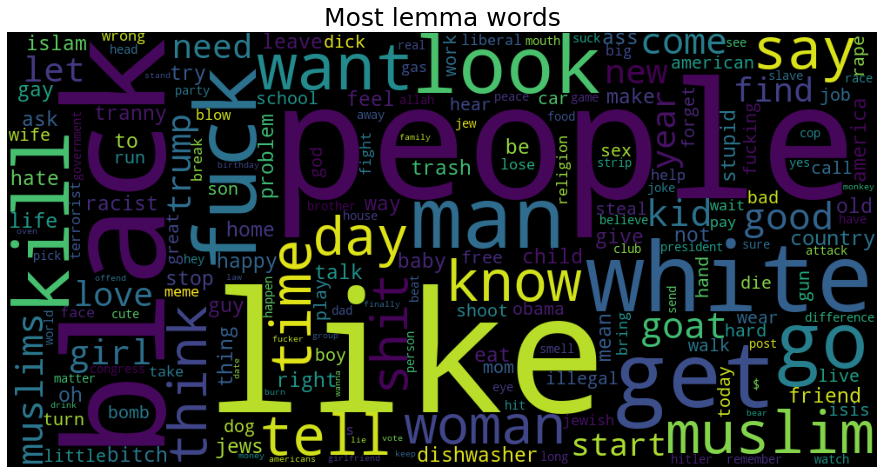

In [17]:
df_token = string_to_token(str_text_total_clean)
dict_word_freq_lemme = list_to_bow(list(df_token['lemme']))
wordcloud = create_wordcloud(dict_word_freq_lemme)
wordcloud = WordCloud(width = 1000, height = 500, normalize_plurals=True).generate_from_frequencies(dict_word_freq_lemme)
plt.figure(figsize=(20,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.title("Most lemma words", fontsize=25)
plt.show

Bag of words size: (28428, 5461)
Unique words size: 5525


<function matplotlib.pyplot.show(*args, **kw)>

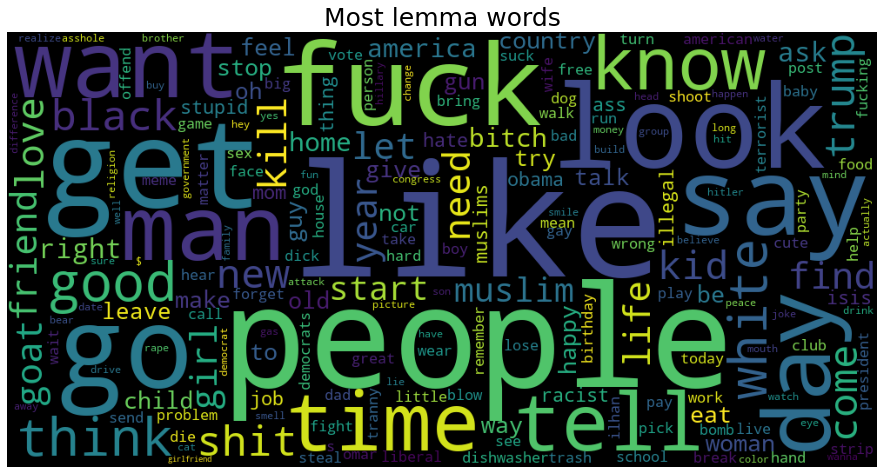

In [18]:
df_token = string_to_token(str_text_total_normal)
dict_word_freq_lemme = list_to_bow(list(df_token['lemme']))
wordcloud = WordCloud(width = 1000, height = 500, normalize_plurals=True).generate_from_frequencies(dict_word_freq_lemme)
plt.figure(figsize=(20,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.title("Most lemma words", fontsize=25)
plt.show

Bag of words size: (19279, 4276)
Unique words size: 4337


<function matplotlib.pyplot.show(*args, **kw)>

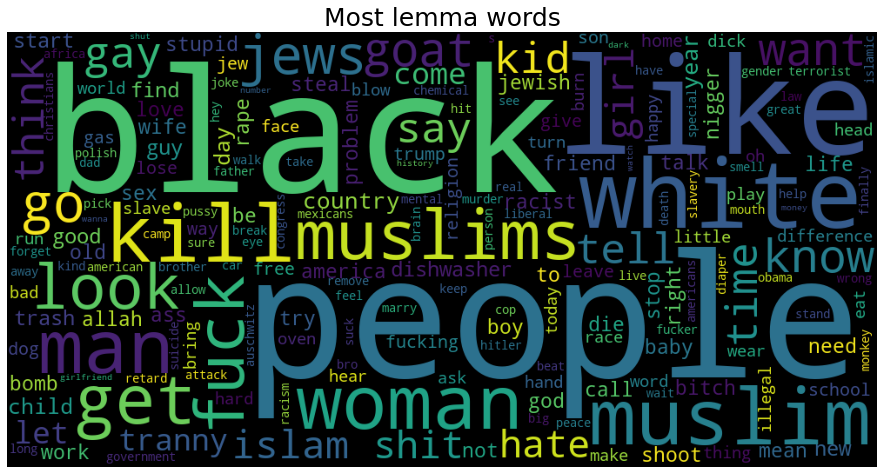

In [19]:
df_token = string_to_token(str_text_total_hateful)
dict_word_freq_lemme = list_to_bow(list(df_token['lemme']))
wordcloud = WordCloud(width = 1000, height = 500, normalize_plurals=True).generate_from_frequencies(dict_word_freq_lemme)
plt.figure(figsize=(20,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.title("Most lemma words", fontsize=25)
plt.show

In [20]:
df_memes_dev['img']   = df_memes_dev['img'].apply(lambda x: clean_image_path(x))
df_memes_train['img'] = df_memes_train['img'].apply(lambda x: clean_image_path(x))
df_memes_test['img']  = df_memes_test['img'].apply(lambda x: clean_image_path(x))
df_memes_dev['text_clean']   = df_memes_dev['text'].apply(lambda x: apply_cleaning(x))
df_memes_train['text_clean'] = df_memes_train['text'].apply(lambda x: apply_cleaning(x))
df_memes_test['text_clean']  = df_memes_test['text'].apply(lambda x: apply_cleaning(x))
df_memes_dev['text_lemma']   = df_memes_dev['text'].apply(lambda x: apply_lemma(x))
df_memes_train['text_lemma'] = df_memes_train['text'].apply(lambda x: apply_lemma(x))
df_memes_test['text_lemma']  = df_memes_test['text'].apply(lambda x: apply_lemma(x))
df_memes_dev.head()

,id,img,label,text,text_clean,text_lemma
0,8291,08291.png,1,white people is this a shooting range,white people shooting range,white people shooting range
1,46971,46971.png,1,bravery at its finest,bravery finest,bravery fine
2,3745,03745.png,1,your order comes to $37.50 and your white priv...,order comes $ white privilege discount brings ...,order come $ white privilege discount bring to...
3,83745,83745.png,1,it is time.. to send these parasites back to t...,time send parasites desert,time send parasite desert
4,80243,80243.png,1,mississippi wind chime,mississippi wind chime,mississippi wind chime


In [26]:
df_memes_dev['img_text']   = df_memes_dev['img'].apply(lambda x: generate_description(x)[0])
# df_memes_train['img'] = df_memes_train['img'].apply(lambda x: clean_image_path(x))
# df_memes_test['img']  = df_memes_test['img'].apply(lambda x: clean_image_path(x))
# res= generate_description('08291.png')
# print(res)

/home/jupyter/meme_hateful_detection/data/raw/facebook_memes/08291.png
/home/jupyter/meme_hateful_detection/data/raw/facebook_memes/46971.png
/home/jupyter/meme_hateful_detection/data/raw/facebook_memes/03745.png
/home/jupyter/meme_hateful_detection/data/raw/facebook_memes/83745.png
/home/jupyter/meme_hateful_detection/data/raw/facebook_memes/80243.png
/home/jupyter/meme_hateful_detection/data/raw/facebook_memes/05279.png
/home/jupyter/meme_hateful_detection/data/raw/facebook_memes/01796.png
/home/jupyter/meme_hateful_detection/data/raw/facebook_memes/53046.png
/home/jupyter/meme_hateful_detection/data/raw/facebook_memes/82301.png
/home/jupyter/meme_hateful_detection/data/raw/facebook_memes/31752.png
/home/jupyter/meme_hateful_detection/data/raw/facebook_memes/27635.png
/home/jupyter/meme_hateful_detection/data/raw/facebook_memes/80597.png
/home/jupyter/meme_hateful_detection/data/raw/facebook_memes/45368.png
/home/jupyter/meme_hateful_detection/data/raw/facebook_memes/17963.png
/home/

In [27]:
df_memes_dev.to_pickle(f'{PATH_INTERIM}/df_memes_dev_clean.pkl') #export pickle
df_memes_train.to_pickle(f'{PATH_INTERIM}/df_memes_train_clean.pkl')
df_memes_test.to_pickle(f'{PATH_INTERIM}/df_memes_test_clean.pkl')

In [ ]:
df_memes_dev  = pd.read_pickle(f'{PATH_INTERIM}/df_memes_dev_clean.pkl')
df_memes_train= pd.read_pickle(f'{PATH_INTERIM}/df_memes_train_clean.pkl')
df_memes_test = pd.read_pickle(f'{PATH_INTERIM}/df_memes_test_clean.pkl')

In [ ]:
tfidf = TfidfVectorizer().fit_transform(df_memes_dev['text'])

In [ ]:
tfidf = TfidfVectorizer()
tfidf.fit(df_memes_dev['text'])
print(tfidf.vocabulary_)

In [ ]:
str_image_clean

In [ ]:
import umap

embedding = umap.UMAP(metric='hellinger', random_state=42).fit_transform(tfidf)

In [ ]:
# embedding
text_colums_umap = pd.DataFrame(embedding)
text_colums_umap.head()

In [ ]:

# you will likely need to restart your kernel to load the models
import spacy

In [ ]:
# load BERT model
# nlp_bert = spacy.load("en_trf_bertbaseuncased_lg", disable=['parser', 'ner'])

# load medium English model
nlp = spacy.load("en_core_web_md", disable=['parser', 'ner'])

# spacy_nlp = spacy.load('en_core_web_sm')
# stopwords = spacy.lang.en.stop_words.STOP_WORDS
# nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner']) 
# nlp.max_length = MAX_NB_WORDS 

In [ ]:
# the spaCy Doc-Span-Token structure is still in place
for model in [nlp]: #[nlp_bert, nlp]:
    print(model.meta['name'])
    parsed = model(text_colums_umap)
    print(type(parsed), type(parsed[0]))
    # but the vector representation is different
    print('Vector shape:', parsed.vector.shape)
    # documents under the transformer model have additional attributes
    print(parsed._.trf_last_hidden_state)

In [ ]:
# Determine CSV, label, and key columns
CSV_COLUMNS = 'weight_pounds,is_male,mother_age,plurality,gestation_weeks,key'.split(',')
LABEL_COLUMN = 'weight_pounds'
KEY_COLUMN = 'key'

# Set default values for each CSV column
DEFAULTS = [[0.0], ['null'], [0.0], ['null'], [0.0], ['nokey']]
TRAIN_STEPS = 1000

In [ ]:
# Create an input function reading a file using the Dataset API
# Then provide the results to the Estimator API
def read_dataset(filename, mode, batch_size = 512):
  def _input_fn():
    def decode_csv(value_column):
      columns = tf.decode_csv(value_column, record_defaults=DEFAULTS)
      features = dict(zip(CSV_COLUMNS, columns))
      label = features.pop(LABEL_COLUMN)
      return features, label
    
    # Create list of files that match pattern
    file_list = tf.gfile.Glob(filename)

    # Create dataset from file list
    dataset = (tf.data.TextLineDataset(file_list)  # Read text file
                 .map(decode_csv))  # Transform each elem by applying decode_csv fn
      
    if mode == tf.estimator.ModeKeys.TRAIN:
        num_epochs = None # indefinitely
        dataset = dataset.shuffle(buffer_size=10*batch_size)
    else:
        num_epochs = 1 # end-of-input after this
 
    dataset = dataset.repeat(num_epochs).batch(batch_size)  
    return dataset
  return _input_fn

In [ ]:
# Define feature columns
def get_categorical(name, values):
  return tf.feature_column.indicator_column(
    tf.feature_column.categorical_column_with_vocabulary_list(name, values))

def get_cols():
  # Define column types
  return [\
          get_categorical('is_male', ['True', 'False', 'Unknown']),
          tf.feature_column.numeric_column('mother_age'),
          get_categorical('plurality',
                      ['Single(1)', 'Twins(2)', 'Triplets(3)',
                       'Quadruplets(4)', 'Quintuplets(5)','Multiple(2+)']),
          tf.feature_column.numeric_column('gestation_weeks')
      ]

In [ ]:
# Create serving input function to be able to serve predictions later using provided inputs
def serving_input_fn():
    feature_placeholders = {
        'is_male': tf.placeholder(tf.string, [None]),
        'mother_age': tf.placeholder(tf.float32, [None]),
        'plurality': tf.placeholder(tf.string, [None]),
        'gestation_weeks': tf.placeholder(tf.float32, [None])
    }
    features = {
        key: tf.expand_dims(tensor, -1)
        for key, tensor in feature_placeholders.items()
    }
    return tf.estimator.export.ServingInputReceiver(features, feature_placeholders)

In [ ]:
# Create estimator to train and evaluate
def train_and_evaluate(output_dir):
  EVAL_INTERVAL = 300
  run_config = tf.estimator.RunConfig(save_checkpoints_secs = EVAL_INTERVAL,
                                      keep_checkpoint_max = 3)
  estimator = tf.estimator.DNNRegressor(
                       model_dir = output_dir,
                       feature_columns = get_cols(),
                       hidden_units = [64, 32],
                       config = run_config)
  train_spec = tf.estimator.TrainSpec(
                       input_fn = read_dataset('train.csv', mode = tf.estimator.ModeKeys.TRAIN),
                       max_steps = TRAIN_STEPS)
  exporter = tf.estimator.LatestExporter('exporter', serving_input_fn)
  eval_spec = tf.estimator.EvalSpec(
                       input_fn = read_dataset('eval.csv', mode = tf.estimator.ModeKeys.EVAL),
                       steps = None,
                       start_delay_secs = 60, # start evaluating after N seconds
                       throttle_secs = EVAL_INTERVAL,  # evaluate every N seconds
                       exporters = exporter)
  tf.estimator.train_and_evaluate(estimator, train_spec, eval_spec)

In [ ]:
# Run the model
shutil.rmtree('babyweight_trained', ignore_errors = True) # start fresh each time
tf.summary.FileWriterCache.clear() # ensure filewriter cache is clear for TensorBoard events file
train_and_evaluate('babyweight_trained')